
# Testing multilabel predictions using example data

Begin by reading in the example data from the example code directory. The example data contains no missing data and should be easy to read in and process.

In [3]:
import pandas as pd
train_phenotypes = pd.read_csv("example_data\example_train_phenotypes.csv", index_col=[0])
train_genotypes = pd.read_csv("example_data\example_train_genotypes.csv", index_col=[0])
test_phenotypes = pd.read_csv("example_data\example_test_phenotypes.csv", index_col=[0])
test_genotypes = pd.read_csv("example_data\example_test_genotypes.csv", index_col=[0])

In [4]:
train_genotypes.head()

,Chromosome_5243_A,Chromosome_5247_T,Chromosome_5248_T,Chromosome_5250_G,Chromosome_5251_A,Chromosome_5254_G,Chromosome_5260_A,Chromosome_5261_A,Chromosome_5265_G,Chromosome_5266_C,...,Chromosome_4408186_T,Chromosome_4408186_A,Chromosome_4408186_C,Chromosome_4408187_C,Chromosome_4408191_C,Chromosome_4408192_T,Chromosome_4408196_A,Chromosome_4408197_T,Chromosome_4408198_C,Chromosome_4408198_A
X,,,,,,,,,,,,,,,,,,,,,
Sample1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sample2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sample3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sample4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sample5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_phenotypes.head()

,rifampicin,isoniazid,ethambutol,pyrazinamide
X,,,,
Sample1,1,1,1,0
Sample2,1,1,0,0
Sample3,1,1,1,1
Sample4,1,1,1,1
Sample5,0,0,0,0



The data is loaded and ready to start the machine learning process. The first step is to address any potential class imbalances. As label powerset addresses multilabel classification by converting it to a multiclass problem, it is possible to perform upsampling to address imbalances in the dataset. This has already been addressed and implemented for multiclass problems.

It is useful to first observe the class imbalances across the training dataset.


<AxesSubplot: >

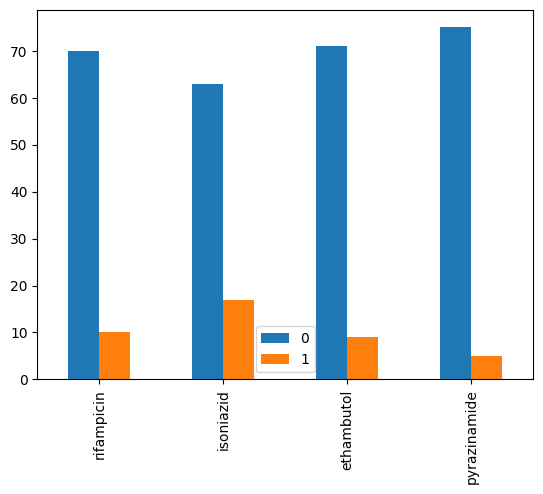

In [6]:
train_phenotypes.apply(pd.value_counts).T.plot.bar() # plot number of each class


The next step is to transform the data to mutliclass and perform oversampling.

In [74]:
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import RandomOverSampler
import numpy as np
lp = LabelPowerset()
y = np.array(train_phenotypes) # convert data frame to numpy array for transformation
x = np.array(train_genotypes) # convert data frame to numpy array for transformation
y = lp.transform(y)
print(y) # visualise transformation
ros = RandomOverSampler(random_state=10, sampling_strategy='not minority') # check sampling strategy
x_resampled, y_resampled = ros.fit_resample(x, y)
y_resampled = lp.inverse_transform(y_resampled) # output is sparse array
#y_resampled_full = y_resampled.toarray()
#y_resampled_full = pd.DataFrame(y_resampled_full, columns= train_phenotypes.columns)

[0 1 2 2 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 0 0 4 2 5 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 3 3 3 3 4 3 3 3 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 3 3 6 3 3 4 3 3 3 3
 3 3 3 3 3 3]


Next step is to perform prediction using label powerset. There are a few things to bear in mind:
* The type of base classifier (select using cross validation)
* Different measures of performance
* Feature importance
* Exploring and dealing with label relations

We will start by performing label powerset prediction, using 5-fold cross validation to select the best estimator. We will not explore or directly deal with label relations for now. The first output will tell us the best estimator and parameters.


In [97]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
parameters = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini'],
        'classifier__n_estimators': [10, 20],
    },
]

clf = GridSearchCV(LabelPowerset(require_dense=[True, True]), parameters, scoring='f1_micro')
#clf.fit(x_resampled, y_resampled)
y = y_resampled.todense()
#x = x_resampled.todense()
clf.fit(x_resampled, y)


GridSearchCV(estimator=LabelPowerset(require_dense=[True, True]),
             param_grid=[{'classifier': [RandomForestClassifier(n_estimators=20)],
                          'classifier__criterion': ['gini'],
                          'classifier__n_estimators': [10, 20]}],
             scoring='f1_micro')

In [9]:
from scipy import sparse
x_test = np.array(test_genotypes)
y_test = np.array(test_phenotypes)
prediction = clf.predict(x_test)
prediction

<20x4 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in List of Lists format>

Now it is time to measure performance...

In [10]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import jaccard_score
hamming = hamming_loss(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)
print(hamming)
print(accuracy)
jaccard_score(y_test, prediction, average='samples')
#jaccard_score(y_test, prediction, average='macro')
#jaccard_score(y_test, prediction, average='micro')
#jaccard_score(y_test, prediction, average=None)
f1_micro = f1_score(y_test, prediction,average=None)
f1_macro = f1_score(y_test, prediction,average=None)
print(f1_micro)
print(f1_macro)
#precision_score(y_test, prediction,average='macro')
#precision_score(y_test, prediction,average='micro')
#recall_score(y_test, prediction,average='micro')
#recall_score(y_test, prediction,average='macro')
#zero_one_loss(y_test, prediction,normalize=True)

0.9
[0. 0. 0. 0.]
[0. 0. 0. 0.]


F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


Now it is time to estimate feature importance. To do this we will use permutation importance. We will perform it on the held out test dataset to


In [60]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, x_test, y_test, n_repeats=2, random_state=42)
print(result)
print(len(result['importances']))

{'importances_mean': array([0., 0., 0., ..., 0., 0., 0.]), 'importances_std': array([0., 0., 0., ..., 0., 0., 0.]), 'importances': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])}
14373


In [121]:
### make into a function - permutation threshold
from numpy import gradient
new_clf = clf.best_estimator_
print(new_clf)
importance_sort = np.argsort(result["importances_mean"])[::-1]
#print(importance_sort)
f1_scores = list(range(0, 10))
for x in range(0, 10):
    if x == 0:
        i = importance_sort[x]
        x_removal = np.delete(x_resampled, i, axis=1)
        x_test_rem = np.delete(x_test, i, axis=1)
        new_clf.fit(x_removal, y)
        prediction_rem = new_clf.predict(x_test_rem)
        f1 = f1_score(y_test, prediction, average="macro")
        f1_scores[x] = f1
    else:
        i = importance_sort[0:x]
        x_removal = np.delete(x_resampled, i, axis=1)
        x_test_rem = np.delete(x_test, i, axis=1)
        new_clf.fit(x_removal, y)
        prediction_rem = new_clf.predict(x_test_rem)
        f1 = f1_score(y_test, prediction, average="macro")
        f1_scores[x] = f1
f1_scores
g = gradient(f1_scores)
zeros = [ i for i,x in enumerate(g) if x.any() == 0 ]
threshold = min(zeros)
print(threshold)



LabelPowerset(classifier=RandomForestClassifier(n_estimators=20),
              require_dense=[True, True])


F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to c

8


F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


In [122]:
### make into another function
new_clf = clf.best_estimator_
## Drop column importance
f1_scores2 = list(range(0, threshold))
for x in range(0, threshold):
    i = importance_sort[x]
    x_removal = np.delete(x_resampled, i, axis=1)
    x_test_rem = np.delete(x_test, i, axis=1)
    new_clf.fit(x_removal, y)
    prediction_rem = new_clf.predict(x_test_rem)
    f1 = f1_score(y_test, prediction, average=None)
    f1_scores2[x] = f1
f1_scores2
importance_each = f1_scores2

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to c

Need to measure the difference between importances!!!!

In [123]:
importance_each

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.])]